In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
import seaborn as sns
sns.set_style("whitegrid")

sys.path.append("../../pyelftools")             # relative location of pyelftools repo cloned from github
from elftools.elf.elffile import ELFFile
from tqdm import tqdm
from scipy import stats
from collections import Counter

In [2]:
path = "armel/"
files = os.listdir(path)
len(files)

8001

In [3]:
np.random.seed(1)
sample_files = np.random.choice(files, size=1000, replace=False)

In [4]:
def extract_code(path, file_list, min_file_size=10000, n_files=100):
    
    code_dict = {}
    counter = 0
    
    for file in file_list:
        with open(path + file, "rb") as f:
            try:
                elffile = ELFFile(f)
            except:
                continue
        
            try:
                text_section_header = elffile.get_section_by_name(".text").header
            except:
                continue
            offset = text_section_header.sh_offset
            size = text_section_header.sh_size
        
            if size >= min_file_size: # minimum size cutoff: 10kb of machine code
                counter += 1
                f.seek(offset)
                code_dict[file] = list(f.read(size))
                if counter == n_files: # number of files to select samples from
                    break
            else:
                continue
                
    return code_dict

In [29]:
sample_code_dict = extract_code(path, sample_files)
len(sample_code_dict.keys())

100

In [6]:
for file, code in sample_code_dict.items():
    print("%s\t%s\t%s" %(file, str(len(code)), code[:10]))

b81b2ee0ca1d8b1ee71cb15ff1bbd9b4	197020	[240, 67, 45, 233, 160, 81, 159, 229, 66, 221]
facf69510fd23a933e1edc228eb1a4f7	12780	[240, 79, 45, 233, 0, 112, 160, 227, 220, 53]
fe4021f7a8855c7e532d13dc9285dfc2	24488	[120, 48, 160, 227, 40, 16, 156, 229, 20, 32]
b3c81e1d80cb4e90e9d973c8ba72f6dc	74092	[8, 64, 45, 233, 109, 255, 255, 235, 7, 0]
592b693d8d74257ef56162385037419e	56248	[8, 64, 45, 233, 60, 16, 159, 229, 5, 32]
302e8646bbb3d2f1c964da9e2f473769	781752	[8, 64, 45, 233, 24, 0, 159, 229, 24, 16]
ebffd6da8e8aee6defe336a8aadfecb6	84236	[15, 0, 82, 227, 240, 65, 45, 233, 0, 48]
09a05ee36350277ceb337472948a5d2c	20652	[3, 0, 160, 227, 8, 64, 45, 233, 12, 16]
27b26a55e3273d464c78f97cb20936b0	92732	[240, 65, 45, 233, 0, 80, 160, 227, 1, 96]
51ff7de0546d5f878d386d061ba3c889	1798160	[8, 64, 45, 233, 0, 48, 144, 229, 12, 48]
20f7d4c5c9c175bf96794581d22bd63c	12832	[240, 79, 45, 233, 0, 96, 160, 227, 80, 166]
b27b05a1f771470519f94497fbf7b751	66576	[12, 16, 159, 229, 8, 64, 45, 233, 0, 0]
503e7d43

In [7]:
def plot_dists(dictionary):
    for file, code in dictionary.items():
        sns.distplot(code, 
                     bins = 256,
                     kde=False,
                     hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':0.1}, 
                     kde_kws={'cumulative': True},
                     norm_hist=True,
                     color="blue")
    plt.show()

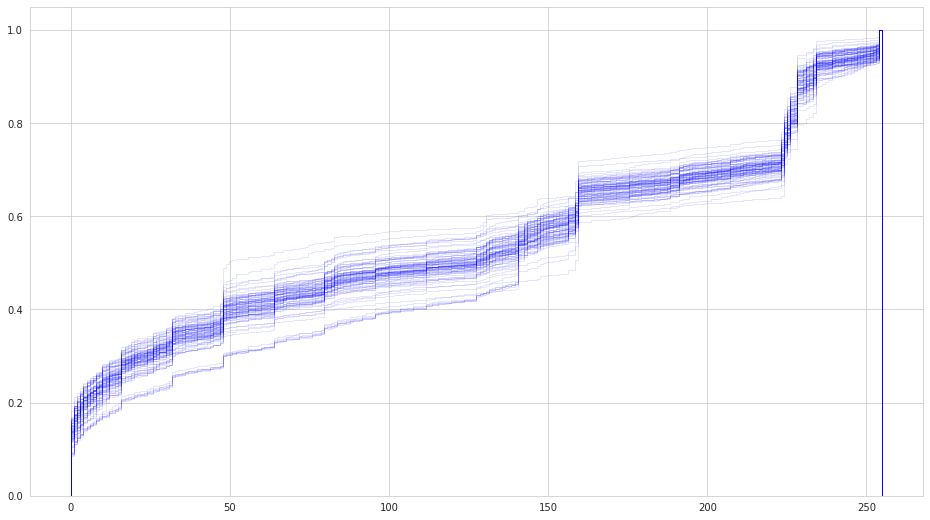

In [8]:
plot_dists(sample_code_dict)

In [9]:
def plot_sample(sample):
    sns.distplot(sample,
                 norm_hist=True,     
                 kde=False,
                 hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':0.1, 'alpha':0.1},
                 kde_kws={'cumulative': True},  # want CDF
                 bins=256,                      
                 color="blue")

def create_code_samples(sample_size, n_rows, sample_source, plot=False):
    
    samples_df = pd.DataFrame(index=np.arange(0, n_rows), columns=[i for i in range(sample_size)])
    
    for i in tqdm(np.arange(0, n_rows)):
        sample = np.random.choice(sample_source, size=sample_size, replace=True)
        samples_df.loc[i] = sorted(sample)
        
    samples_mean = samples_df.mean(axis = 0)
    
    if plot is True:
        sns.distplot(samples_mean, norm_hist=True, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},kde_kws={'cumulative': True},bins=256,color="red")
        plt.show()    
    
    return samples_mean

In [10]:
def create_reference_distribution(code_dictionary, sample_size, n_samples):
    # create data frame to hold mean sample of each file's code
    means_df = pd.DataFrame(index=list(code_dictionary.keys()),
                            columns=[i for i in range(sample_size)])
    
    # for each file's code, store mean of the samples in data frame
    for file, code in code_dictionary.items():
        means_df.loc[file] = create_code_samples(sample_size,
                                                 n_samples,
                                                 code)
    # average all samples means together
    mean = means_df.mean(axis = 0)
    median = means_df.median(axis = 0)
    return mean, median

In [11]:
mean, median = create_reference_distribution(sample_code_dict, 1000, 1000)

100%|██████████| 1000/1000 [02:15<00:00,  7.36it/s]


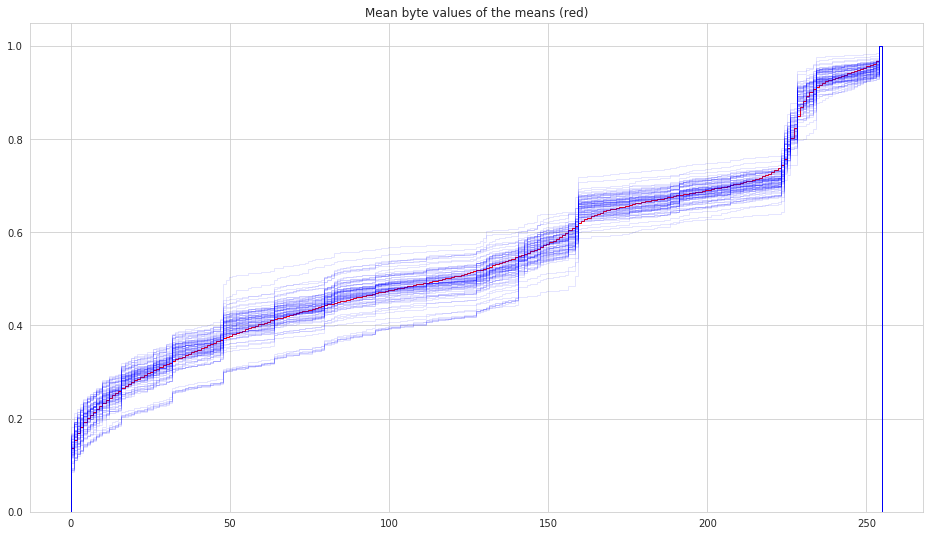

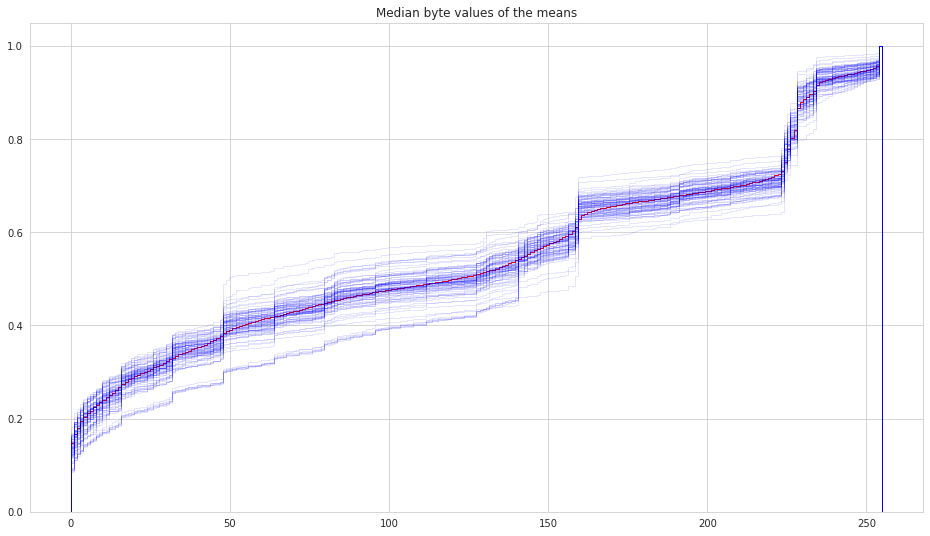

In [12]:
sns.distplot(mean, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Mean byte values of the means (red)")
plot_dists(sample_code_dict)


sns.distplot(median, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Median byte values of the means")
plot_dists(sample_code_dict)

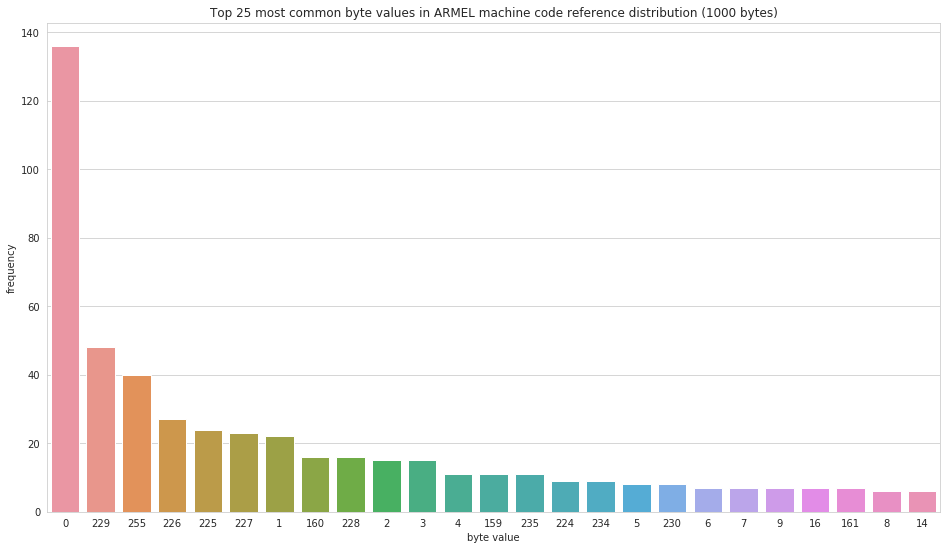

In [13]:
rounded_medians = [round(i) for i in median]
sorted_counts = sorted(Counter(rounded_medians).items(), key = lambda x: x[1], reverse=True)

counts_df = pd.DataFrame(sorted_counts[:25])
counts_df = counts_df.rename(columns={0:"byte value", 1:"frequency"})

sns.barplot(x="byte value", y="frequency", data=counts_df, order=counts_df["byte value"])
plt.title("Top 25 most common byte values in ARMEL machine code reference distribution (1000 bytes)")
plt.show()

In [14]:
[hex(i) for i in list(dict(sorted_counts).keys())[:25]]

['0x0',
 '0xe5',
 '0xff',
 '0xe2',
 '0xe1',
 '0xe3',
 '0x1',
 '0xa0',
 '0xe4',
 '0x2',
 '0x3',
 '0x4',
 '0x9f',
 '0xeb',
 '0xe0',
 '0xea',
 '0x5',
 '0xe6',
 '0x6',
 '0x7',
 '0x9',
 '0x10',
 '0xa1',
 '0x8',
 '0xe']

In [15]:
# get pool of test files
test_pool = [file for file in files if file not in sample_files]

# select test files
np.random.seed(1)
test_files = np.random.choice(test_pool, size=3000, replace=False)

In [16]:
len(test_files)

3000

In [17]:
# check for overlap between files that the reference distribution was built from and the files used for testing
list(set(sample_code_dict.keys()) & set(test_files))

[]

In [18]:
test_code_dict = extract_code(path, test_files, n_files=3000)

for file, code in test_code_dict.items():
    print("%s\t%s\t%s" % (file, str(len(code)), code[:10]))

4f026fa06f62cd06e0cac7f455d718d1	70952	[8, 64, 45, 233, 106, 255, 255, 235, 7, 0]
75dfcae7b472dc940a68306c22056bc0	51192	[240, 79, 45, 233, 12, 153, 159, 229, 12, 57]
3fb952e32a02a5f5271a70a83014109c	49092	[0, 176, 160, 227, 0, 224, 160, 227, 4, 16]
4cb4fbc778a6f98162794803676352e8	1146436	[56, 64, 45, 233, 80, 48, 159, 229, 80, 32]
542bc2b1e770540783442f3b1a2b5711	652688	[8, 64, 45, 233, 24, 0, 159, 229, 24, 16]
06814970e960f901269b5b355d0dcbc4	893740	[0, 176, 160, 227, 0, 224, 160, 227, 4, 16]
57a6be45827108aab21b467823e0aa48	70484	[0, 176, 160, 227, 0, 224, 160, 227, 4, 16]
c771d4527f0f8ec97ab445934f450d59	58928	[56, 64, 45, 233, 0, 64, 81, 226, 0, 80]
b457ac1e0382650b566eb201f4384dad	91316	[56, 64, 45, 233, 80, 48, 159, 229, 80, 32]
22df0ede6de4644b41aa0240d9975a53	79116	[240, 79, 45, 233, 1, 128, 160, 225, 120, 103]
c94ed1494fe9d4b1951717565f7369b9	12604	[240, 79, 45, 233, 0, 64, 160, 225, 1, 80]
54fcedb58f94df9afcc834ebab70eca1	26192	[8, 64, 45, 233, 0, 48, 144, 229, 12, 48]
3d29

In [19]:
len(test_code_dict.keys())

826

In [20]:
test_results_df = pd.DataFrame(index=test_code_dict.keys(),
                               columns=["size", "wasserstein distance","energy distance", "mean", "median", "standard deviation"])

for file, code in test_code_dict.items():
    test_results_df.loc[file]["size"] = len(code)
    test_results_df.loc[file]["wasserstein distance"] = stats.wasserstein_distance(median, code)
    test_results_df.loc[file]["energy distance"] = stats.energy_distance(median, code)
    test_results_df.loc[file]["mean"] = np.mean(code)
    test_results_df.loc[file]["median"] = np.median(code)
    test_results_df.loc[file]["standard deviation"] = np.std(code)
    
print(test_results_df.shape)
test_results_df

(826, 6)


,size,wasserstein distance,energy distance,mean,median,standard deviation
4f026fa06f62cd06e0cac7f455d718d1,70952,13.2322,1.39552,127.506,141,89.0499
75dfcae7b472dc940a68306c22056bc0,51192,2.54546,0.274216,113.351,116,93.9763
3fb952e32a02a5f5271a70a83014109c,49092,4.59803,0.48504,111.1,92,96.1572
4cb4fbc778a6f98162794803676352e8,1146436,2.43206,0.280192,117.318,131,94.2742
542bc2b1e770540783442f3b1a2b5711,652688,2.35734,0.260862,117.552,131,94.9419
...,...,...,...,...,...,...
e63c878c4af56d7eab5dcee6e33f0d38,49868,5.01249,0.514331,110.799,89,96.4777
a8c5905c66a88f7c3333b925ecb63a66,56732,3.99003,0.420304,117.976,131,93.0733
332bc28cfac6e6aa40503c8945700b14,162612,3.14101,0.328261,118.357,131,94.6899
fcffed72799f4428d040807c3edb55ca,225936,1.50519,0.163154,115.667,125,94.9926


In [21]:
test_results_df.mean()

size                    146671.539952
wasserstein distance         4.981564
energy distance              0.507812
mean                       115.660517
median                     117.673729
standard deviation          95.258654
dtype: float64

In [22]:
test_results_df.median()

size                    42542.000000
wasserstein distance        3.926586
energy distance             0.401497
mean                      114.991451
median                    125.000000
standard deviation         95.491076
dtype: float64

In [23]:
test_results_df["size"].sum()

121150692

In [24]:
test_results_df["size"].sum() / 1000000

121.150692

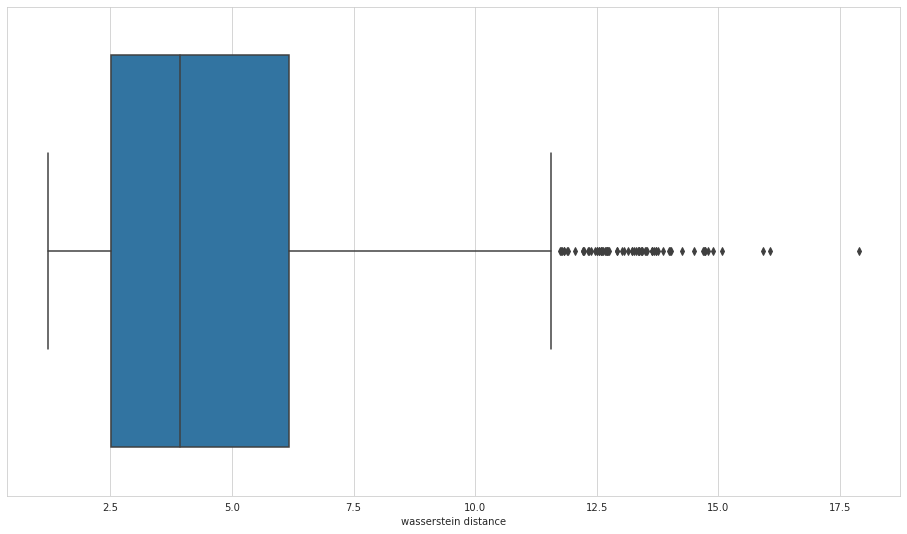

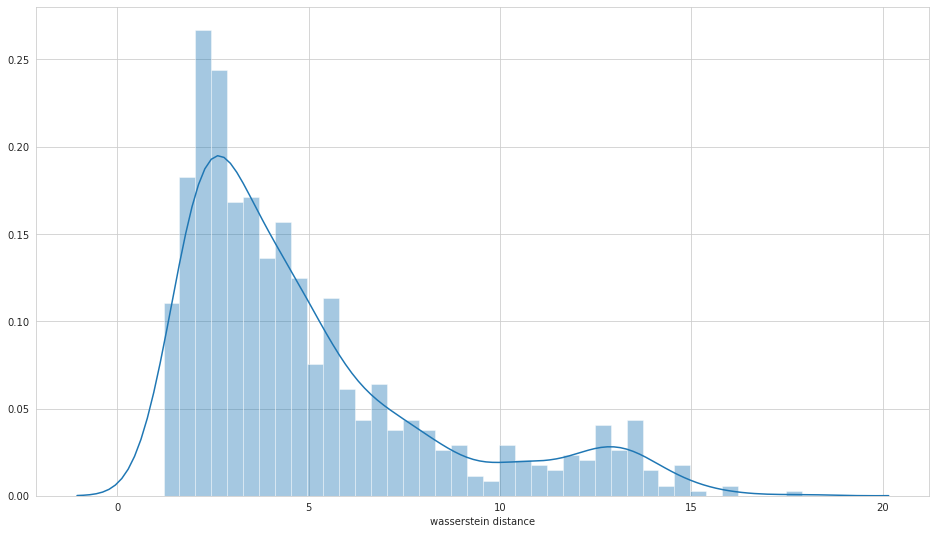

In [25]:
sns.boxplot(x="wasserstein distance", data=test_results_df)
plt.show()
sns.distplot(test_results_df["wasserstein distance"], bins=40)
plt.show()

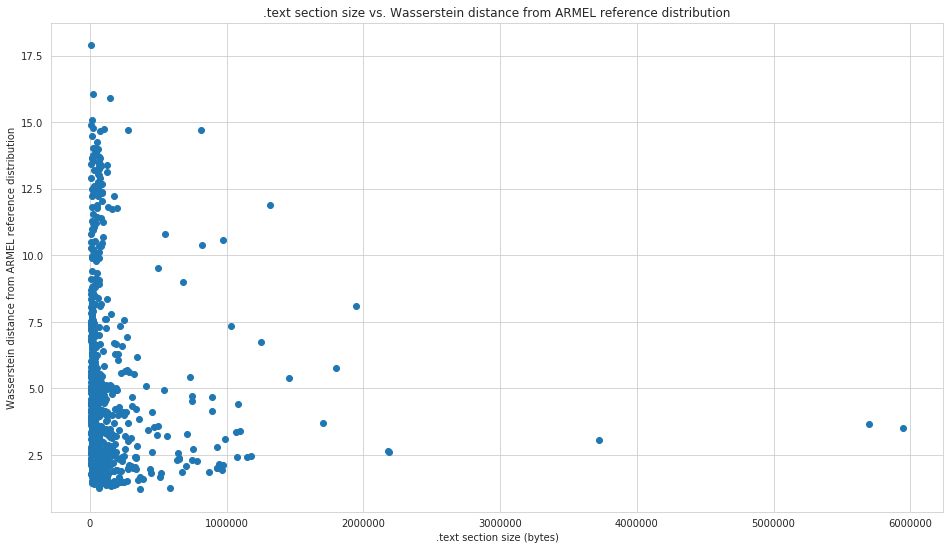

In [26]:
plt.scatter(test_results_df["size"], test_results_df["wasserstein distance"])
plt.xlabel(".text section size (bytes)")
plt.ylabel("Wasserstein distance from ARMEL reference distribution")
plt.title(".text section size vs. Wasserstein distance from ARMEL reference distribution")
plt.show()

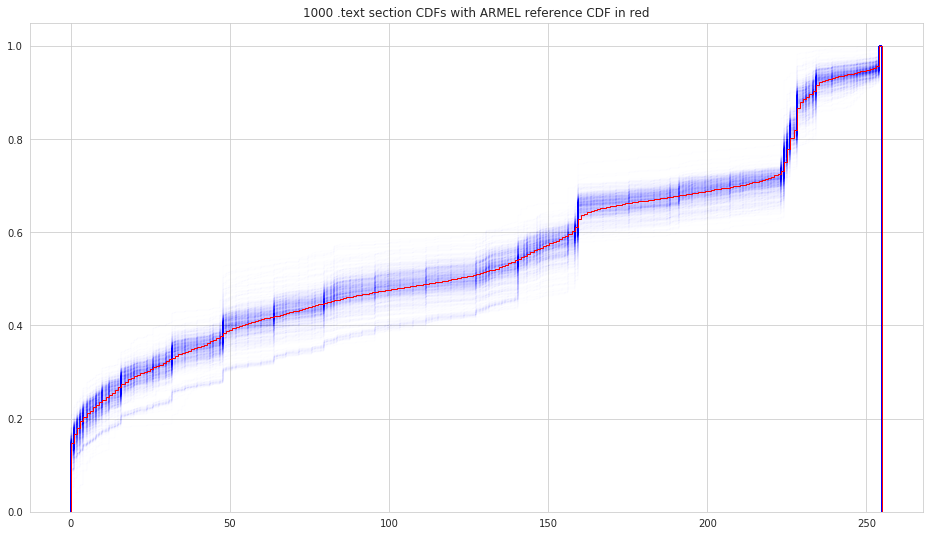

In [30]:
for code in test_code_dict.values():
    plot_sample(code)
    
sns.distplot(median, # reference distribution
             norm_hist=True,     
             kde=False,
             hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},
             kde_kws={'cumulative': True},
             bins=256,                      
             color="red")

plt.title("1000 .text section CDFs with ARMEL reference CDF in red")
plt.show()

In [28]:
# export reference distribution
with open("ARMEL_reference", "wb") as f:
    pickle.dump(median, f)